# **Titanic Survival Prediction**

**Author:** Milos Saric [https://saricmilos.com/]  
**YOUTUBE: English: @realskillsoverdegrees  Serbian: @saricmilos**  
**Date:** October 7, 2025  
**Dataset:** Titanic Passenger Data  

---

This notebook explores the classic Titanic dataset to predict passenger survival using machine learning.  
The analysis will guide you through the full data science workflow, including:

1. **Problem Definition** – Clearly outline the objective and scope of the project.

2. **Data Collection** – Gather relevant datasets from KAGGLE.

3. **Exploratory Data Analysis (EDA)** – Analyze and visualize data to uncover patterns and insights.

4. **Feature Engineering** – Create, transform, or select meaningful features to improve model performance.

5. **Model Development** – Build and train predictive or analytical models.

6. **Evaluation & Testing** – Assess model performance using appropriate metrics and validate results.

The goal of this project is to apply practical data science techniques to a real-world dataset and gain insights into the factors that influenced survival on the Titanic.


## 1. **Problem Definition**

This phase involves clearly understanding the challenge we aim to solve. This step sets the foundation for the entire project and ensures all efforts are aligned toward a common goal.

Key aspects include:

- **Objective**: Predict whether a passenger survived the Titanic disaster based on available features such as age, gender, class, fare and newly created features.  

- **Scope**: The analysis focuses on the provided Titanic dataset. Predictions are limited to the passengers listed in the dataset, without considering external historical data or additional features beyond what is provided.  

- **Stakeholders**:  
  - **Data Scientists / ML Practitioners**: To practice and improve predictive modeling skills.  
  - **Kaggle Community**: Participants competing in the Titanic challenge.  
  - **Educators / Students**: Learning tool for understanding classification problems and feature engineering.  

- **Success Criteria**: Achieve high prediction accuracy on the test dataset, evaluated using metrics such as **accuracy score**. A successful model reliably distinguishes between survivors and non-survivors.

>A well-defined problem statement is half the solution!


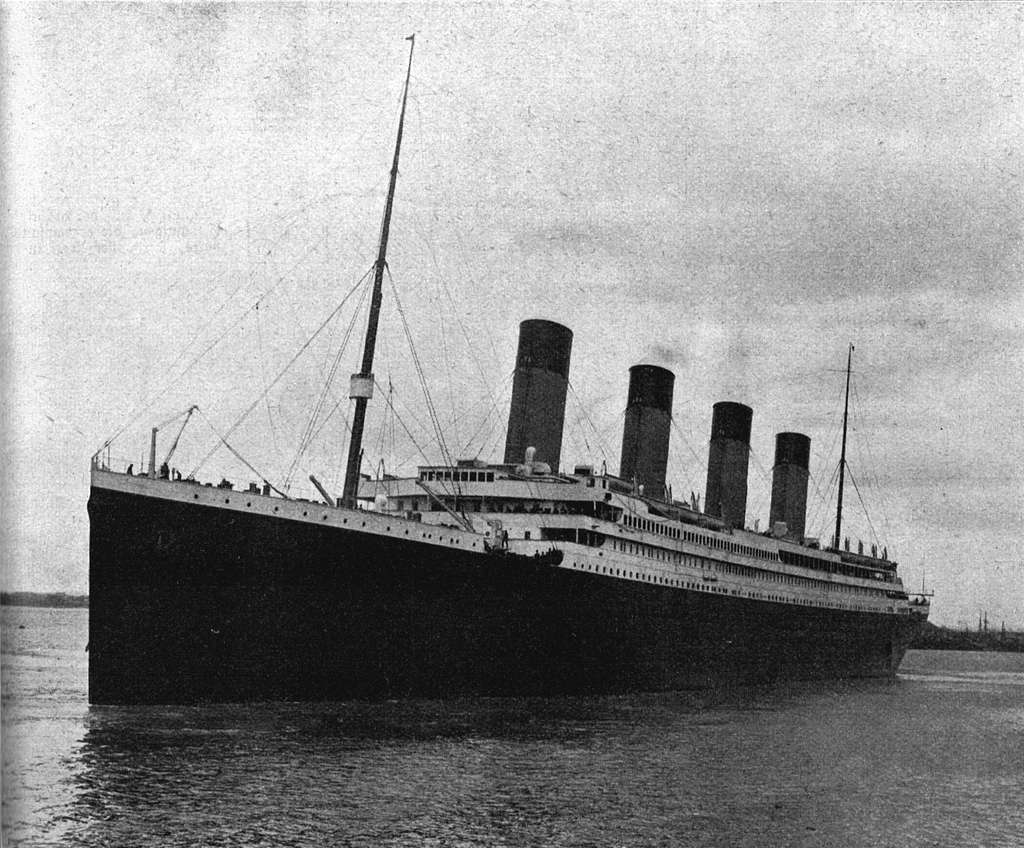

In [1]:
from IPython.display import Image

Image(filename=r"C:\Users\Milos\Desktop\ESCAPE 9-5\PYTHON\GitHub Kaggle Projects\1. Titanic Survival Predictor\Images\titanic.jpg")

## **2. Data Collection**

The **Data Collection** phase is all about gathering the data we need and setting up the tools for analysis. In this step, we also import essential libraries and create reusable functions to streamline our workflow.
The training and testing datasets for this project are provided by Kaggle. You can either:

 - **1.** Download them directly from my GitHub: https://github.com/saricmilos/titanic-survival-prediction

 - **2.** Or access them from Kaggle itself: Titanic: Machine Learning from Disaster

Both sources contain the same dataset, so you can choose whichever is more convenient.

## **2.1. Import Libraries**
   Import libraries for data handling, visualization, and modeling:  

In [2]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Any
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

#HyperParameters
from sklearn.model_selection import GridSearchCV

## **2.2. Create Reusable Functions**
Functions to avoid repetitive tasks and keep code clean:

### **2.2.1. Data Loading**

In [3]:
# Load our datasets
def load_dataset(csv_path: Path, **read_csv_kwargs: Any) -> pd.DataFrame:
    """     
    Load a CSV file into a pandas DataFrame.
    
    Args:
        csv_path (Path): Full path to the CSV file
        **read_csv_kwargs: Optional arguments for pd.read_csv

    Returns:
        pd.DataFrame
     """
    if not csv_path.exists():
        raise FileNotFoundError(f"CSV file not found: {csv_path}")
    return pd.read_csv(csv_path, **read_csv_kwargs)

### **2.2.1. Data Preparation**

In [4]:
# Function to extract title from the name
def extract_title(name):
    match = re.search(r", (\w+)\.",name)
    return match.group(1) if match else "Unknown"

In [5]:
# Create a column containing each passenger title as categorical numerical value
def process_titles(df, rare_titles, title_mapping):
    """
    Extracts and encodes passenger titles into numeric categories.
    
    Parameters:
    - df: DataFrame, the dataset to process
    - rare_titles: list of titles to group as 'Rare'
    - title_mapping: dict mapping titles to numeric values
    
    Returns:
    - df: DataFrame with a new 'Title' column encoded numerically
    """
    # Extract titles
    df['Title'] = df['Name'].apply(extract_title)
    
    # Replace rare titles
    df['Title'] = df['Title'].replace(rare_titles, 'Rare')
    
    # Ensure all remaining titles exist in the mapping
    df['Title'] = df['Title'].apply(lambda x: x if x in title_mapping else 'Unknown')
    
    # Map to numeric
    df['Title'] = df['Title'].map(title_mapping)
    
    return df

In [6]:
# Function to determine size of the family from number of family members (cousins, children, parents):
def family_category(size):
    if size == 1:
        return "Single"
    elif size <= 4:
        return "SmallFamily"
    else:
        return "LargeFamily"

In [7]:
# Creates a column for family oriented features (size of the family, travelling alone, number of members in each person family)
def process_family_features(df, family_category_func, family_mapping):
    """
    Adds family-related features to a DataFrame:
    - FamilySize: total number of family members aboard
    - FamilyCategory: categorical encoding of family size
    - IsAlone: 1 if the passenger is alone, 0 otherwise

    Parameters:
    - df: pandas DataFrame
    - family_category_func: function to categorize family size
    - family_mapping: dict mapping family categories to numeric values

    Returns:
    - df: DataFrame with new family features
    """
    # Compute family size
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    
    # Categorize family size and map to numeric
    df["FamilyCategory"] = df["FamilySize"].apply(family_category_func).map(family_mapping)
    
    # Flag passengers who are alone
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
    
    return df


In [8]:
def process_age_features(df, bins, labels, age_mapping):
    """
    Adds age-related features to a DataFrame:
    - AgeMissing: 1 if Age is missing, 0 otherwise
    - Age: fills missing values using median per Title
    - AgeGroup: numeric age group for modeling

    Parameters:
    - df: pandas DataFrame
    - bins: list of numeric bin edges for age groups
    - labels: list of labels for each age group
    - age_mapping: dict mapping age group labels to numeric codes

    Returns:
    - df: DataFrame with new age features
    """
    # Flag missing ages
    df["AgeMissing"] = df["Age"].isna().astype(int)
    
    # Fill missing ages with median per Title
    df["Age"] = df.groupby("Title")["Age"].transform(lambda x: x.fillna(x.median()))
    
    # Categorize ages into bins
    age_groups = pd.cut(df["Age"], bins=bins, labels=labels)
    
    # Map labels to numeric codes and convert to integer
    df["AgeGroup"] = age_groups.map(age_mapping).astype(int)
    
    return df

In [9]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name=None, labels=None, figsize=(6, 4), normalize=False):
    """
    Plot a confusion matrix using Seaborn.
    
    Parameters:
        y_true : array-like, true labels
        y_pred : array-like, predicted labels
        model_name : str, optional, name of the model for the title
        labels : list, optional, class labels
        figsize : tuple, optional, size of the figure
        normalize : bool, optional, normalize counts to percentages
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d",
                cmap="Blues", cbar=False,
                xticklabels=labels if labels is not None else True,
                yticklabels=labels if labels is not None else True)
    
    title = "Confusion Matrix"
    if model_name:
        title += f" - {model_name}"
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [10]:
def process_fare_bins(df, column="Fare", bins=4, labels=None):
    """
    Converts a continuous fare column into quantile-based bins, handling missing values,
    and ensures the bin column is numeric.

    Parameters:
    - df: pandas DataFrame
    - column: column name to bin
    - bins: number of quantile bins
    - labels: list of labels for each bin (numeric or categorical)

    Returns:
    - df: DataFrame with new 'FareBin' column as numeric
    """
    # Fill missing fares with median
    df[column] = df[column].fillna(df[column].median())
    
    if labels is None:
        labels = list(range(bins))
    
    # Create quantile bins
    fare_groups = pd.qcut(df[column], q=bins, labels=labels)
    
    # Convert to numeric
    df["FareBin"] = fare_groups.astype(int)
    
    return df

In [11]:
def encode_categorical(df, column, encoding_type="onehot", prefix=None, dummy_na=True):
    """
    Encodes a categorical column in different ways and drops the original column.
    
    Parameters:
    - df: pandas DataFrame
    - column: column name to encode
    - encoding_type: str, type of encoding: "onehot" or "label"
    - prefix: string to prefix dummy columns (only for one-hot encoding)
    - dummy_na: bool, include a column for NaNs (only for one-hot encoding)
    
    Returns:
    - df: DataFrame with encoded column(s)
    """
    
    if encoding_type == "onehot":
        if prefix is None:
            prefix = column
        # One-hot encode with optional NaN column
        dummies = pd.get_dummies(df[column], prefix=prefix, dummy_na=dummy_na).astype(int)
        df[dummies.columns] = dummies
        df.drop(columns=[column], inplace=True)
    
    elif encoding_type == "label":
        # Label encode
        le = LabelEncoder()
        # Fill NaN temporarily to encode
        df[column] = df[column].fillna("NaN")  
        df[column] = le.fit_transform(df[column])
    
    else:
        raise ValueError("Unsupported encoding_type. Choose 'onehot' or 'label'.")
    
    return df

In [12]:
def process_deck(df, all_decks):
    """
    Extract deck from Cabin and one-hot encode it,
    ensuring all columns exist and are in consistent order.
    Drops the original Cabin column.
    """
    # Extract deck, fill missing as "Missing"
    df["Deck"] = df["Cabin"].apply(lambda x: str(x)[0] if pd.notna(x) else "Missing")
    
    # One-hot encode
    deck_dummies = pd.get_dummies(df["Deck"], prefix="Deck").astype(int)
    
    # Add missing columns
    for col in all_decks:
        if col not in deck_dummies:
            deck_dummies[col] = 0
    
    # Ensure column order
    deck_dummies = deck_dummies[all_decks]
    
    # Add one-hot columns to DataFrame
    df[all_decks] = deck_dummies
    
    # Drop original Cabin column
    df.drop(columns=["Cabin"], inplace=True)
    
    return df

In [13]:
def process_ticket(df, ticket_counts=None):
    """
    Processes the Ticket column:
    - Adds TicketGroupSize
    - Optionally extracts TicketPrefix
    - Drops original Ticket column

    Parameters:
    - df: pandas DataFrame
    - ticket_counts: precomputed ticket counts (dict or Series). 
                     If None, computes from df.

    Returns:
    - df: processed DataFrame
    - ticket_counts: Series of ticket counts
    """
    if ticket_counts is None:
        ticket_counts = df['Ticket'].value_counts()
    
    # Ticket group size
    df['TicketGroupSize'] = df['Ticket'].map(ticket_counts)
    
    # Ticket prefix
    df['TicketPrefix'] = df['Ticket'].apply(lambda x: str(x).split()[0] if not str(x).isdigit() else 'None')
    
    # Drop original ticket
    df.drop(columns=['Ticket'], inplace=True)
    
    return df, ticket_counts

### **2.2.3. Data Visualization**

In [14]:
# Function to plot most important features
def plot_feature_importance(model, feature_names, top_n=15):
    # Some models (like XGBoost/RandomForest) have 'feature_importances_'
    importance = model.feature_importances_
    fi = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(8, 6))
    plt.barh(fi['Feature'], fi['Importance'])
    plt.gca().invert_yaxis()
    plt.title(f"Top {top_n} Feature Importances for {type(model).__name__}")
    plt.xlabel("Importance Score")
    plt.show()

In [15]:
def bar_chart(feature, dataset_name='train', datasets=None):
    """
    Plots a stacked bar chart of Survived vs Not Survived counts for a given feature.
    Shows counts on bars and percentages in parentheses.
    """
    if datasets is None or dataset_name not in datasets:
        raise ValueError("Dataset not found in datasets dictionary")
    
    df = datasets[dataset_name]

    # Count values for each group
    counts = df.groupby(['Survived', feature],observed=False).size().unstack(fill_value=0)

    # Plot stacked bar
    ax = counts.T.plot(kind='bar', stacked=True, figsize=(10,6), color=['red','green'])
    
    plt.title(f'Survival by {feature.capitalize()}')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Survived', labels=['Not Survived', 'Survived'])

    # Add counts with percentages on bars
    for i, col in enumerate(counts.columns):
        total = counts[col].sum()  # total for this feature value
        bottom = 0
        for j in range(len(counts)):
            height = counts.iloc[j, i]
            if height > 0:
                percent = height / total * 100
                ax.text(
                    i,  # x-coordinate = bar index
                    bottom + height / 2,
                    f'{int(height)} ({percent:.1f}%)',
                    ha='center', va='center', color='white', fontsize=10
                )
            bottom += height
    
    plt.tight_layout()
    plt.show()
    
    return counts


## **2.3. Load Datasets**

In [16]:
dataset_folder = Path(r"C:\Users\Milos\Desktop\ESCAPE 9-5\PYTHON\GitHub Kaggle Projects\1. Titanic Survival Predictor\Data")
datasets = {}

In [17]:
for csv_file in dataset_folder.glob("*.csv"):
    datasets[csv_file.stem] = load_dataset(csv_file)

In [18]:
print(f"{datasets.keys()}")

dict_keys(['gender_submission', 'test', 'train'])


##  **3. Exploratory Data Analysis (EDA)**

Exploratory Data Analysis is all about **understanding the dataset**, uncovering patterns, spotting anomalies, and generating insights that will guide feature engineering and modeling.

## What Caused the “Unsinkable” Titanic to Go Down?

1. **11:40 pm** – Titanic strikes an iceberg, seawater flooding her bow.  
2. **12:00 am** – With the keel tilted upward, massive stress strains the hull.  
3. **2:15 am** – The hull begins to break apart; Titanic splits along a joint.  
4. **2:18 am** – The wheelhouse crumbles under the force of the sea.  
5. **2:20 am** – The stern rises into the sky, floats for a brief, followed by Titanic sinking into the Atlantic.

---

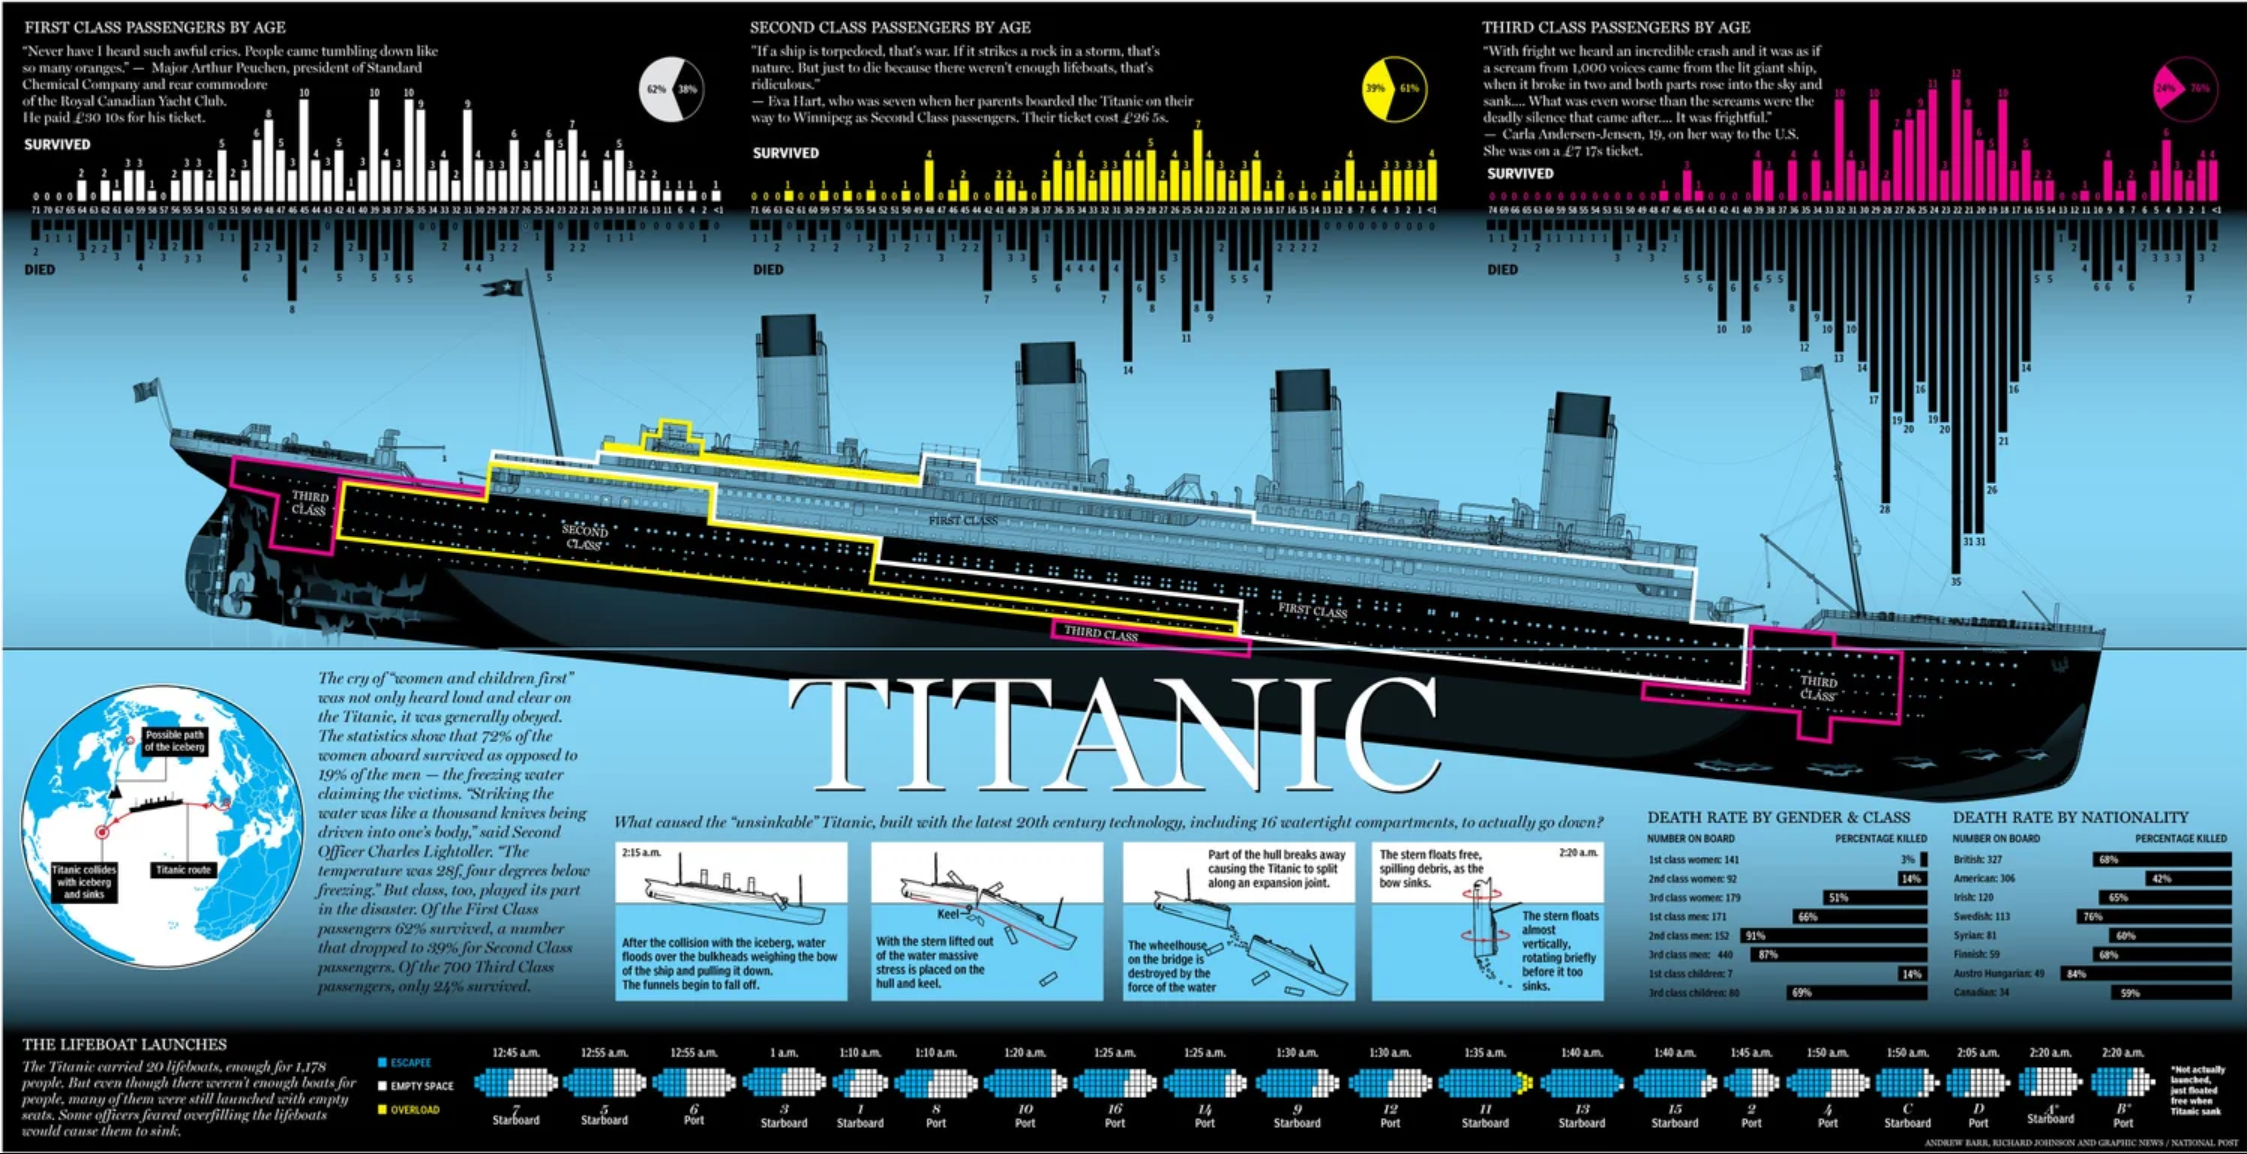

In [19]:
Image(filename=r"C:\Users\Milos\Desktop\ESCAPE 9-5\PYTHON\GitHub Kaggle Projects\1. Titanic Survival Predictor\Images\howtitanicsank.png")

Printing first 5 rows of training dataset.

In [20]:
datasets["train"].head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

##  **Data Dictionary**

| Feature       | Description |
|---------------|-------------|
| **PassengerId** | Unique identifier for each passenger |
| **Survived**    | Survival status (0 = No, 1 = Yes) |
| **Pclass**      | Passenger class (1 = 1st, 2 = 2nd, 3 = 3rd) |
| **Name**        | Full name of the passenger |
| **Sex**         | Gender of the passenger (male/female) |
| **Age**         | Age of the passenger in years |
| **SibSp**       | Number of siblings or spouses aboard the Titanic |
| **Parch**       | Number of parents or children aboard the Titanic |
| **Ticket**      | Ticket number |
| **Fare**        | Passenger fare (in British pounds) |
| **Cabin**       | Cabin number |
| **Embarked**    | Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton) |



There are 891 rows and 12 columns in our training dataset.

In [21]:
datasets["train"].shape

(891, 12)

In [22]:
datasets["train"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The test dataset contains 418 rows and 11 columns. Note that unlike the training dataset, it **does not include the target column `Survived`**, which we aim to predict using our model.

In [23]:
datasets["test"].shape

(418, 11)

In [24]:
datasets["test"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


We can observe that several features have missing values:

- **Age**: Out of 891 rows in the training dataset, the Age is available for only 714 passengers, meaning 177 values are missing.  
- **Cabin**: The Cabin feature is missing for the majority of passengers, with only 204 out of 891 rows containing a value.
- **Embarked**: The Embarked feature is missing 2 values.    

> Missing values are important to identify, as they may affect model performance and will need to be handled during data preprocessing.


In [25]:
datasets["train"].isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

It's important to inspect the **test dataset** for missing values before making predictions. The missing values for each column are as follows:

- **Age**: Out of 418 rows in the test dataset, the Age is available for only **332 passengers**, meaning **86 values are missing**.  
- **Cabin**: The Cabin feature is missing for most passengers, with only **91 out of 418 rows** containing a value.  
- **Fare**: There is **1 missing value** in the Fare column.

> Identifying missing values in the test dataset is important, as they need to be handled properly to ensure accurate predictions from our model.


In [26]:
datasets["train"][datasets["train"]["Survived"] == 1]["Sex"].value_counts()

Sex
female    233
male      109
Name: count, dtype: int64

In [27]:
datasets["test"].isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [28]:
datasets["train"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## **3.1. Bar Charts for Categorical Features**

## Women and Children First
The cry of *"women and children first"* echoed across the decks of the Titanic.  
And it was obeyed.  

While chaos spread through the freezing night, women and children were guided into lifeboats. Many men stepped back, allowing others a chance at survival. Some lived. Many did not.  

The fate of each soul depended not only on courage, but also on where they stood on the ship when the iceberg struck.

---

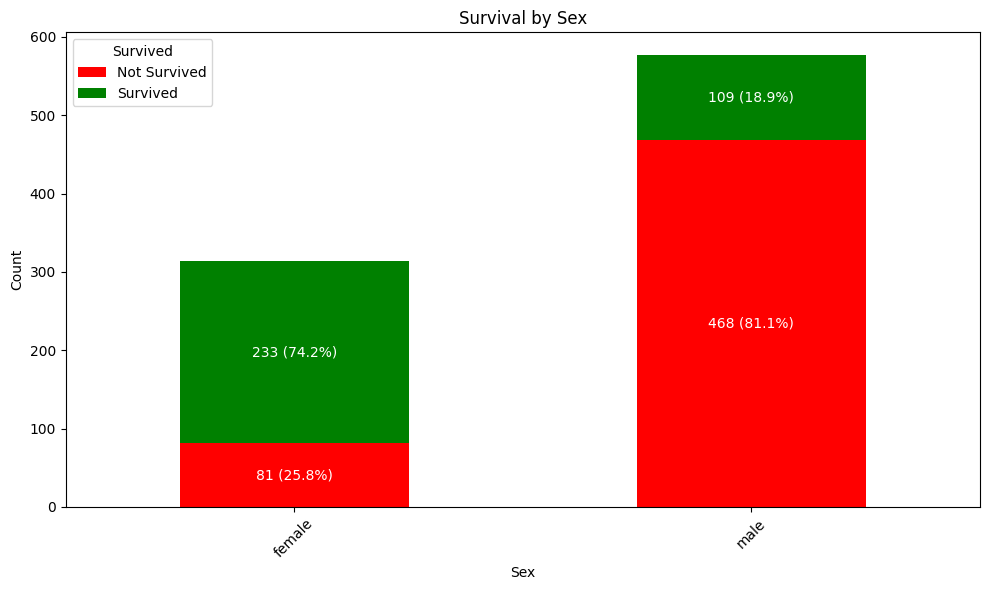

In [29]:
survived_sex = bar_chart("Sex","train",datasets)

## Passenger Class and Survival

The decks of the Titanic were divided not just by cabins, but by **class**—first, second, and third.  
Where you slept often determined whether you lived or perished.  

First-class passengers had easier access to lifeboats, wider staircases, and closer proximity to the deck. Second-class passengers had fewer advantages, and third-class passengers faced long corridors and locked gates.  

In the chaos of the sinking, survival was not just about courage, it was shaped by **where you were in the ship’s hierarchy**.

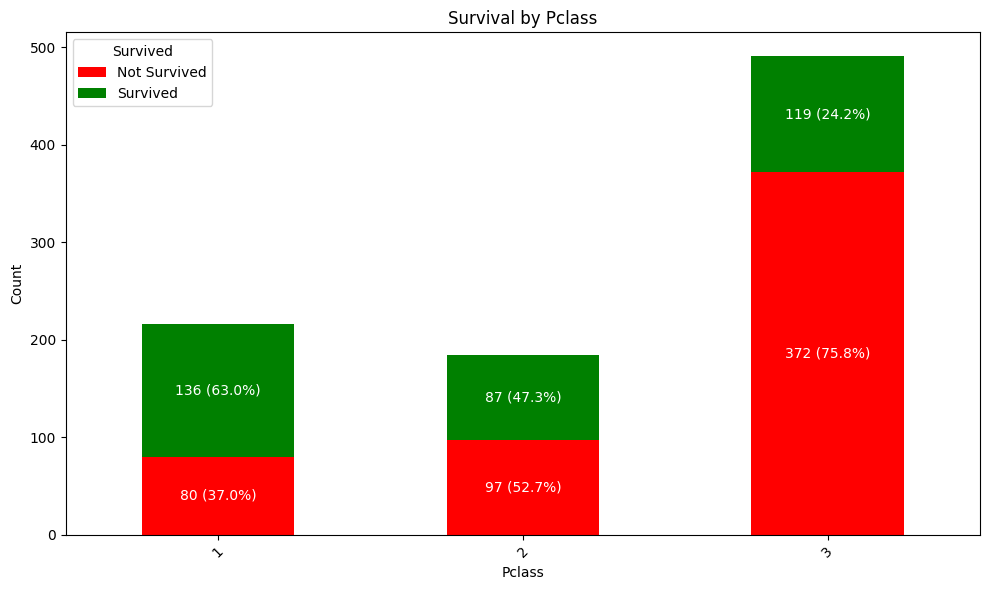

In [30]:
survived_class = bar_chart("Pclass","train",datasets)

## Port of Embarkation and Survival

Where passengers boarded the Titanic—**Southampton (S), Cherbourg (C), or Queenstown (Q)**—also influenced their chances of survival.  
The port was more than a starting point; it often reflected class, cabin location, and access to lifeboats.  

Passengers who boarded at **Cherbourg (C)** were more likely to be first-class and closer to the upper decks, giving them a higher chance of survival. Those from **Southampton (S)** and **Queenstown (Q)** included more second- and third-class passengers, who faced longer routes to safety and crowded corridors.  

In the tragedy of that night, survival was shaped not only by courage, but also by **where you entered the ship**.

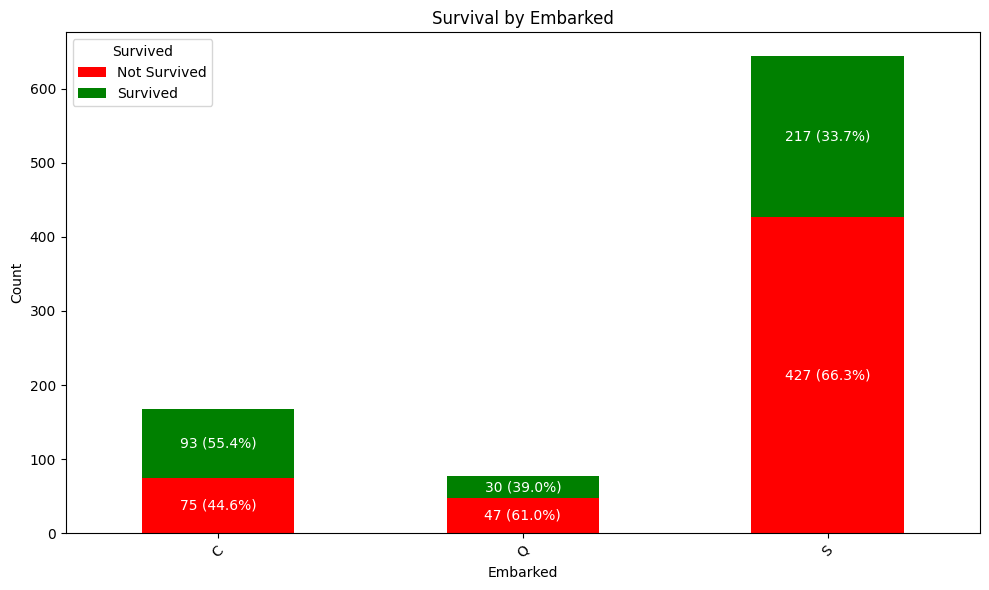

In [31]:
survived_embarked = bar_chart("Embarked","train",datasets)

In [32]:
label_counts = datasets['train']["Survived"].value_counts()
print(label_counts)


label_percentages = datasets['train']["Survived"].value_counts(normalize=True) * 100
print(label_percentages)

Survived
0    549
1    342
Name: count, dtype: int64
Survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64


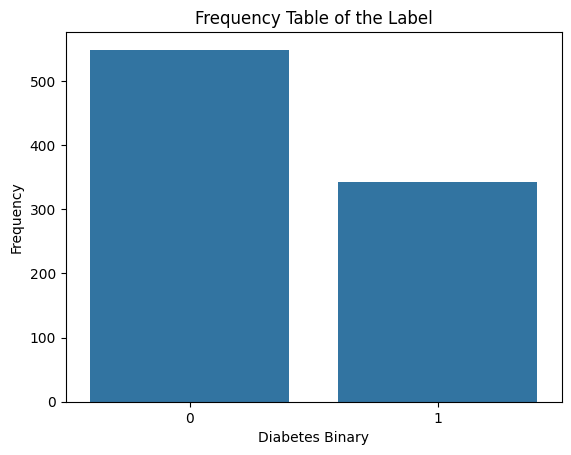

Total number of labels:  891


In [33]:
x = datasets["train"]["Survived"].value_counts().values 
labels = datasets["train"]["Survived"].value_counts().index 

# Use the correct syntax for barplot
sns.barplot(x=labels, y=x)
plt.title('Frequency Table of the Label')
plt.xlabel('Diabetes Binary')
plt.ylabel('Frequency')
plt.show()

# Print the total number of labels
print('Total number of labels: ', sum(x))

### Correlation matrix

In [34]:
corr = datasets["train"].select_dtypes(include=["number"]).corr(method="spearman")
corr1 = corr.abs()

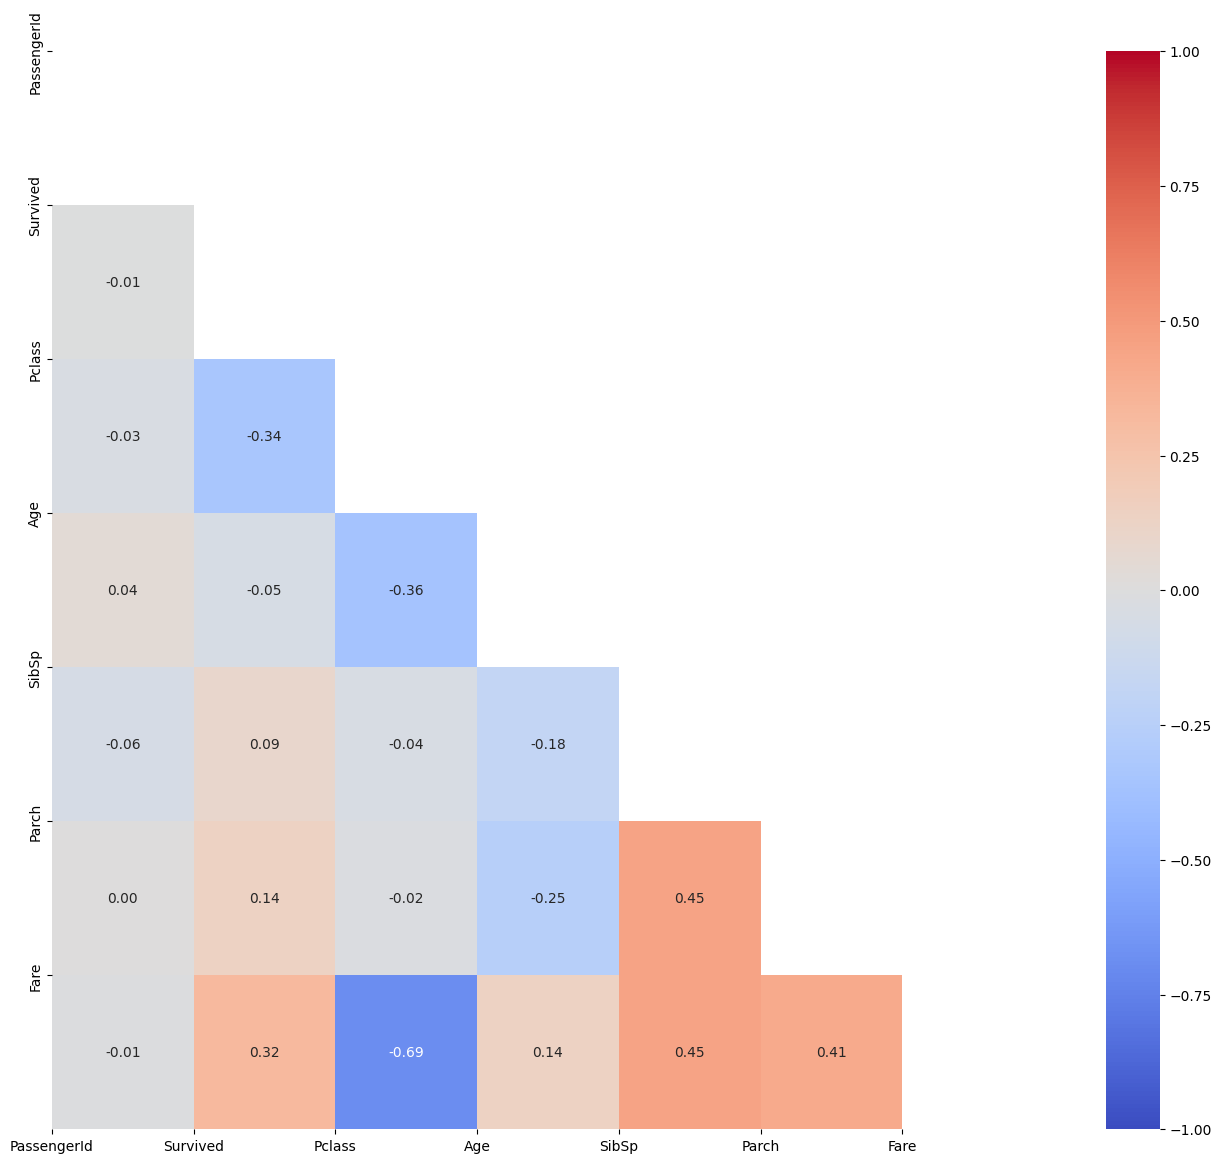

In [35]:
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
  
f, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(corr, annot=True, fmt=".2f", mask=mask, cmap="coolwarm", vmin=-1, vmax=1)
    # xticks
plt.xticks(range(len(corr.columns)), corr.columns);
    # yticks
plt.yticks(range(len(corr.columns)), corr.columns)
    # plot
plt.show()

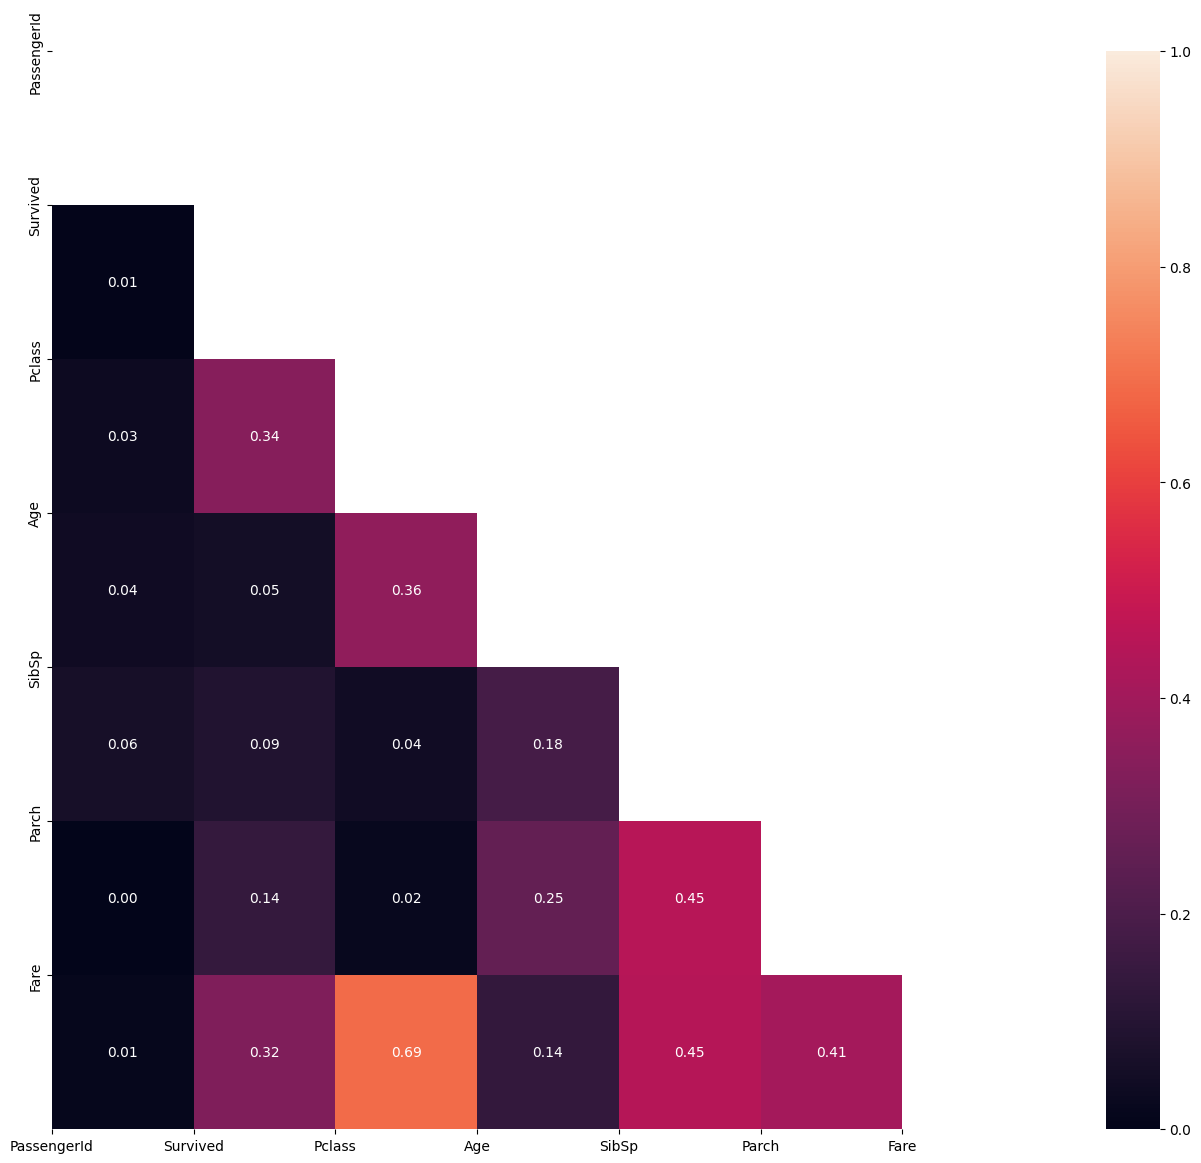

In [36]:
mask = np.zeros_like(corr1, dtype=bool)
mask[np.triu_indices_from(mask)] = True
  
f, ax = plt.subplots(figsize=(16, 14))

sns.heatmap(corr1, annot=True, fmt=".2f", mask=mask, vmin=0, vmax=1)
    # xticks
plt.xticks(range(len(corr1.columns)), corr1.columns);
    # yticks
plt.yticks(range(len(corr1.columns)), corr1.columns)
    # plot
plt.show()

In [37]:
datasets["train"]["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [38]:
datasets["train"].describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

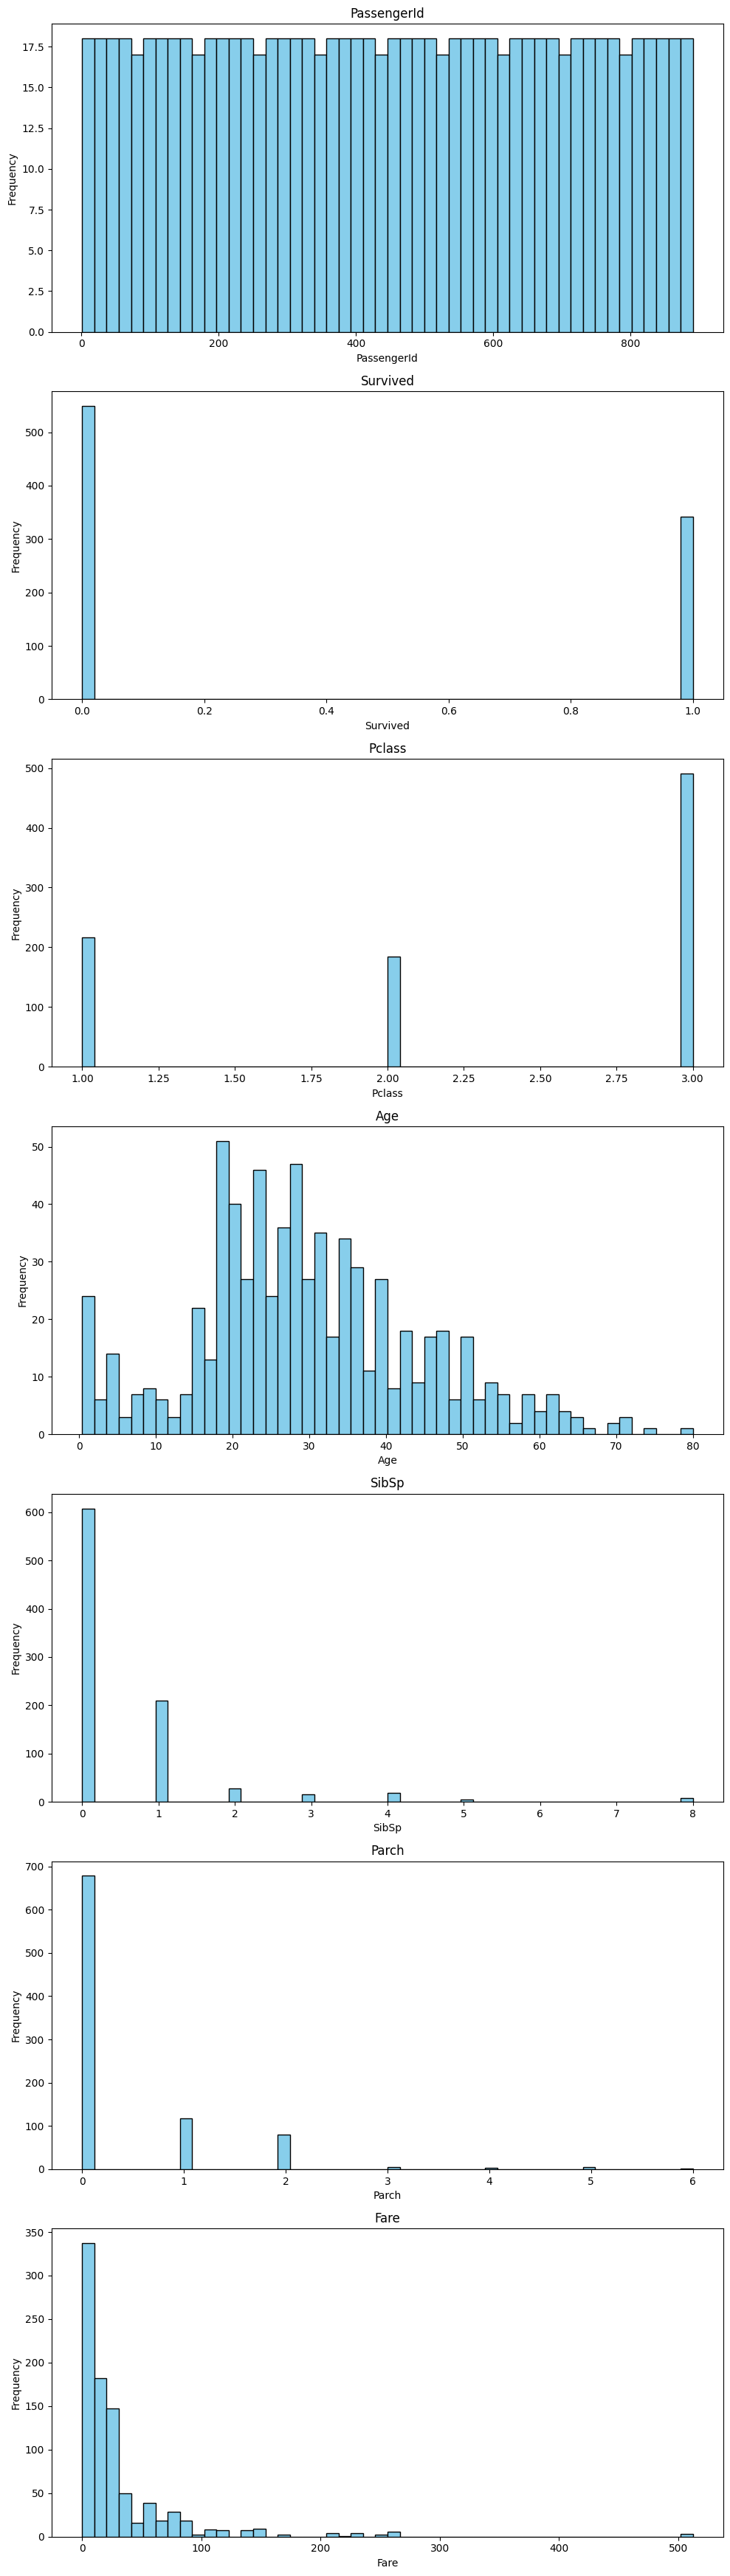

In [39]:
numeric_cols = datasets["train"].select_dtypes(include='number').columns
fig, axes = plt.subplots(nrows=len(numeric_cols), ncols=1, figsize=(10, 5*len(numeric_cols)))

for ax, col in zip(axes, numeric_cols):
    ax.hist(datasets["train"][col], bins=50, color='skyblue', edgecolor='black')
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

## **4. Feature Engineering**

Feature engineering is the process of **transforming raw data into meaningful features** that improve model performance.  
It involves creating new variables, encoding categorical data, handling missing values, and selecting the most informative attributes.  

Good feature engineering leverages insights from Exploratory Data Analysis (EDA) to **highlight patterns, enhance predictive power, and make the data more suitable for modeling**.


### 5.1. Title of Each Passenger

The **title** of a passenger, contained in each passengers name, such as *Mr*, *Mrs*, *Miss*, or *Master* provides valuable information about their **social status, age group, and gender**.  

Titles can help us understand survival patterns on the Titanic, as certain groups (like women and children) were more likely to survive.  
Rare or unusual titles are grouped into a **"Rare"** category to simplify the analysis, and missing titles are labeled as **"Unknown"**.  

By converting titles into **numeric categories**, we create a feature that can improve predictive modeling.


In [40]:
rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Mlle', 'Countess', 'Ms', 'Lady', 
               'Jonkheer', 'Don', 'Capt', 'Sir']
title_mapping = {"Mr":0, "Miss":1, "Mrs":2, "Master":3, "Rare":4, "Unknown":5}

In [41]:
for key in ['train', 'test']:
    datasets[key] = process_titles(datasets[key], rare_titles, title_mapping)

In [42]:
datasets["train"].isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

In [43]:
datasets["test"].isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Title            0
dtype: int64

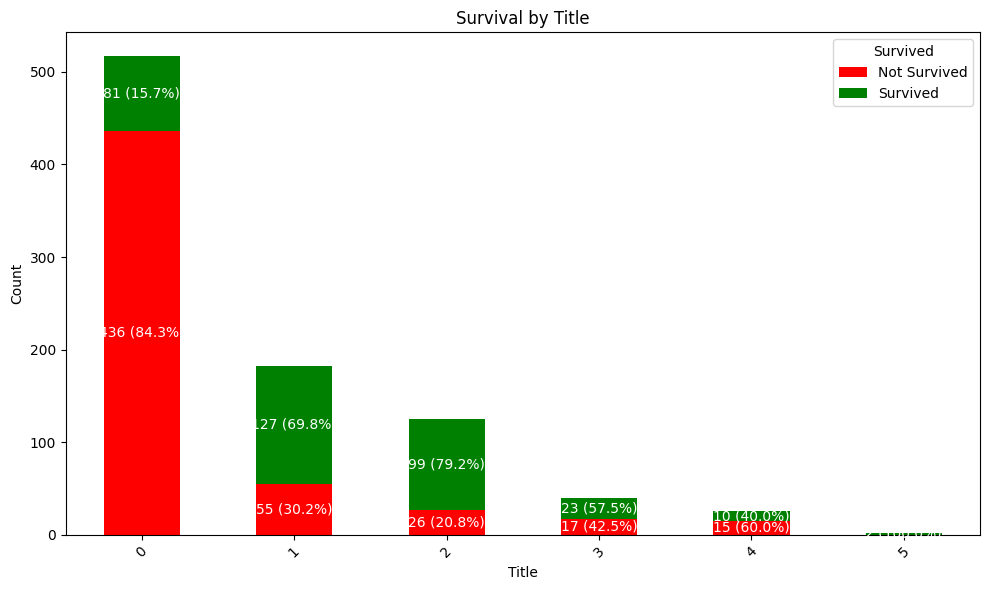

In [44]:
survived_title = bar_chart("Title","train",datasets)

### 5.2. Family Size

The **family size** of a each passenger is calculated as the sum of siblings/spouses (`SibSp`) and parents/children (`Parch`) aboard, plus one for the passenger themselves can provide insights into survival patterns.  

Passengers traveling alone often had different survival chances compared to those in larger families. To capture this, we create additional features:  

- **FamilySize**: total number of family members aboard  
- **FamilyCategory**: a categorical representation of family size (e.g., Single, Small, Large)  
- **IsAlone**: a binary indicator of whether the passenger was traveling alone  

These features help models understand **social dynamics and group behavior**, which were crucial factors during the Titanic disaster.

In [45]:
family_mapping = {'Single': 0, 'SmallFamily': 1, 'LargeFamily': 2}

In [46]:
for key in ["train", "test"]:
    datasets[key] = process_family_features(datasets[key], family_category, family_mapping)

In [47]:
datasets["train"].isna().sum()

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age               177
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin             687
Embarked            2
Title               0
FamilySize          0
FamilyCategory      0
IsAlone             0
dtype: int64

In [48]:
datasets["test"].isna().sum()

PassengerId         0
Pclass              0
Name                0
Sex                 0
Age                86
SibSp               0
Parch               0
Ticket              0
Fare                1
Cabin             327
Embarked            0
Title               0
FamilySize          0
FamilyCategory      0
IsAlone             0
dtype: int64

In [49]:
datasets["train"]["FamilySize"].value_counts()

FamilySize
1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: count, dtype: int64

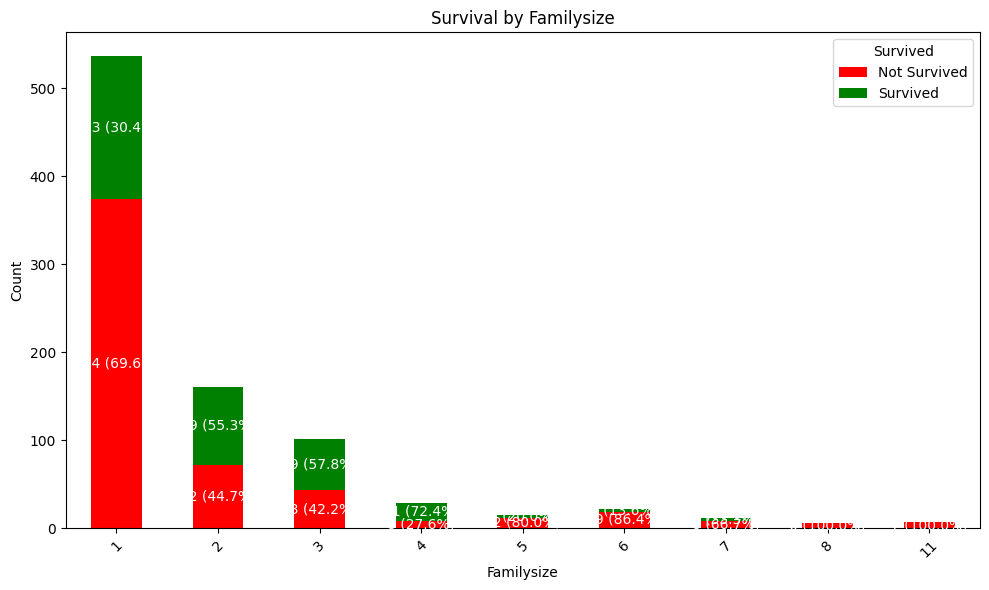

In [50]:
survived_familysize = bar_chart("FamilySize","train",datasets)

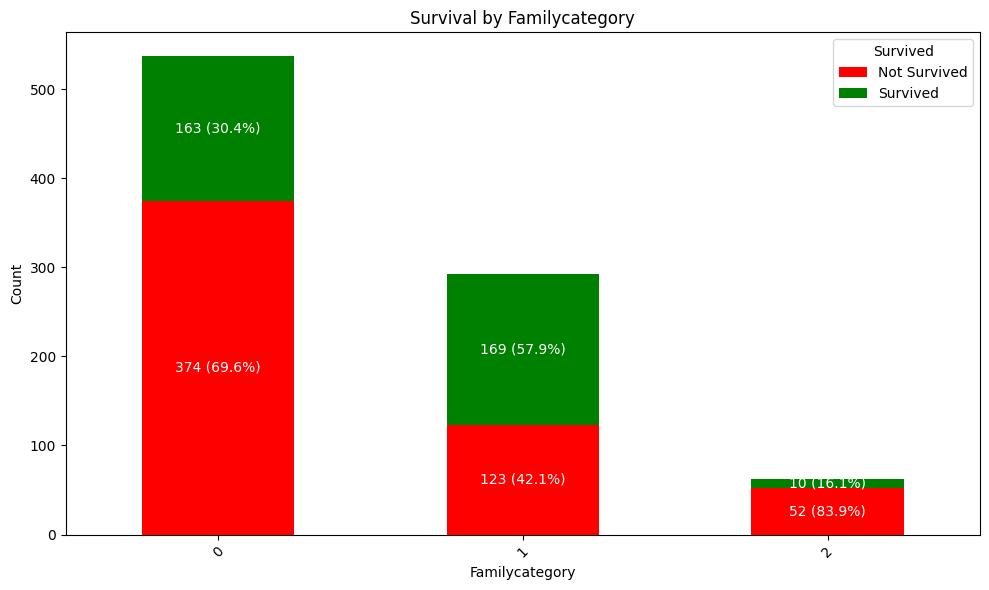

In [51]:
survived_familycategoty = bar_chart("FamilyCategory","train",datasets)

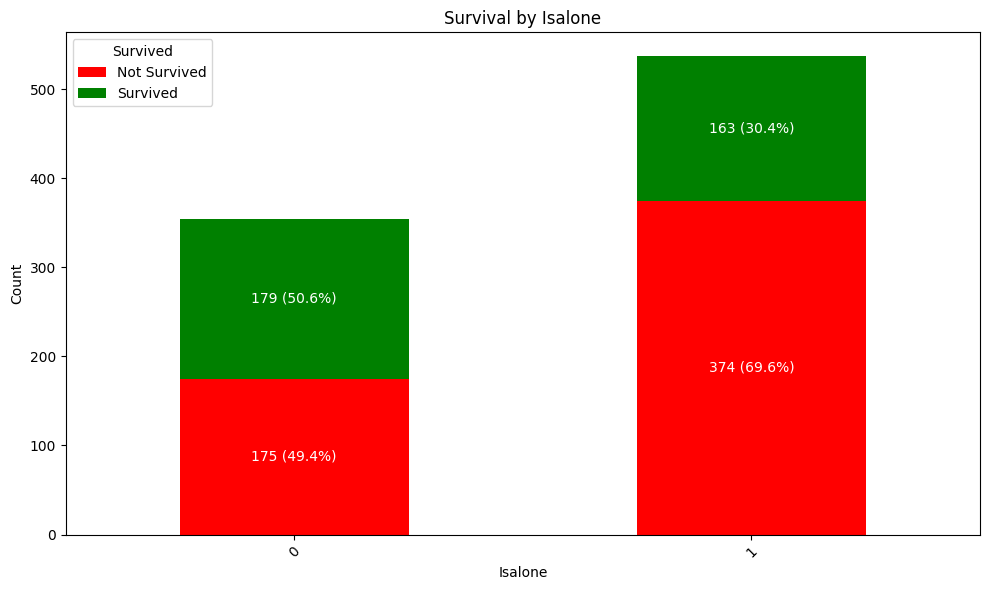

In [52]:
survived_isalone = bar_chart("IsAlone","train",datasets)

### 5.3) Age Category

A passenger's **age** played a role in survival on the Titanic, as children and younger passengers were often prioritized during evacuation.  

To capture this, we create the following features:  

- **AgeMissing**: a flag indicating if the age was missing, which can itself be informative  
- **Age**: missing ages are filled using the median age of passengers with the same **Title**, preserving social/age patterns  
- **AgeGroup**: passengers are categorized into **Child, Teen, Adult, MiddleAge, and Senior**, and these groups are mapped to numeric codes for modeling  

These age-related features help the model understand patterns related to **age and survival**, while handling missing or


In [53]:
bins = [0,12,18,35,60,120]
labels = ["Child","Teen","Adult","MiddleAge","Senior"]
age_mapping = {"Child": 0,"Teen": 1,"Adult": 2,"MiddleAge": 3,"Senior": 4}

In [54]:
for key in ["train","test"]:
    datasets[key] = process_age_features(datasets[key],bins,labels,age_mapping)

In [55]:
datasets["train"].isna().sum()

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin             687
Embarked            2
Title               0
FamilySize          0
FamilyCategory      0
IsAlone             0
AgeMissing          0
AgeGroup            0
dtype: int64

In [56]:
datasets["test"].isna().sum()

PassengerId         0
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                1
Cabin             327
Embarked            0
Title               0
FamilySize          0
FamilyCategory      0
IsAlone             0
AgeMissing          0
AgeGroup            0
dtype: int64

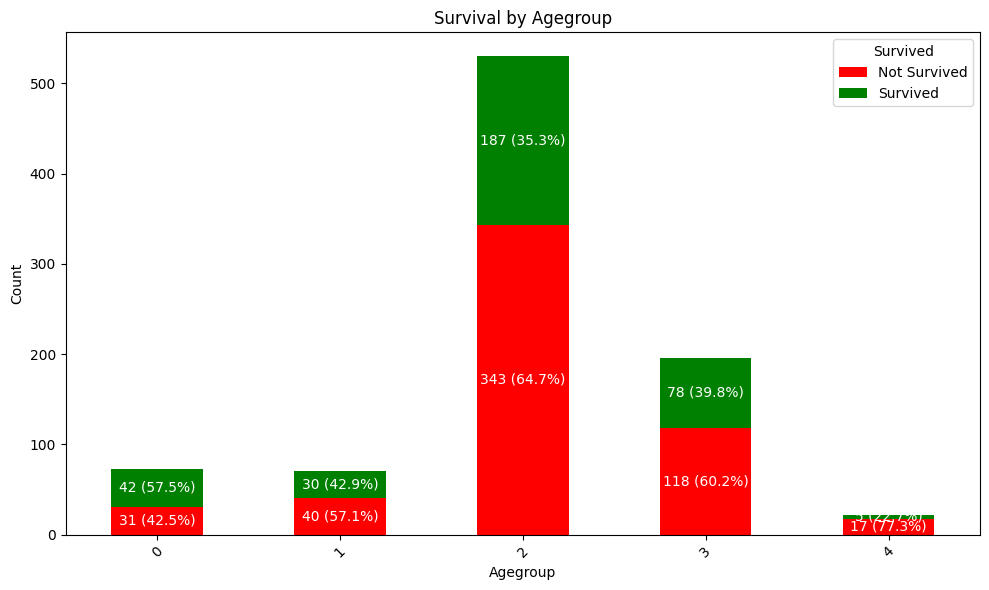

In [57]:
survived_age = bar_chart("AgeGroup","train",datasets)

In [58]:
datasets["train"].head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  Title  FamilySize  \
0      0         A/5 21171   7.2500   NaN        S      0           2   
1      0          PC 17599  71.2833   C85        C      2           2   
2      0  STON/O2. 3101282   7.9250   NaN        S      1           1   
3      0            113803  53.1000  C123        S      2           2   
4      0            373450   8.0500   NaN        S      0           1   

   FamilyCategory  IsAlone  AgeMissing  AgeGroup  
0               1        0           0         2  
1               1        0           0         3  
2               0        1           0         2  
3               1        0           0         2  
4               0        1           0         2

### 5.4. Fare Prices Category

Ticket fares on the Titanic varied greatly, from a few pounds to extravagant sums.  
Because the distribution of fares is highly **skewed**, we convert the continuous `Fare` values into **four quantile-based categories** (quartiles).  

- **FareBin**: divides passengers into 4 groups (0 = lowest fares, 3 = highest fares)  
- This reduces the effect of extreme outliers and allows the model to capture **relative wealth levels** more effectively.  

In [59]:
for key in ["train", "test"]:
    datasets[key] = process_fare_bins(datasets[key])

In [60]:
datasets["train"].isna().sum()

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin             687
Embarked            2
Title               0
FamilySize          0
FamilyCategory      0
IsAlone             0
AgeMissing          0
AgeGroup            0
FareBin             0
dtype: int64

In [61]:
datasets["test"].isna().sum()

PassengerId         0
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin             327
Embarked            0
Title               0
FamilySize          0
FamilyCategory      0
IsAlone             0
AgeMissing          0
AgeGroup            0
FareBin             0
dtype: int64

### 5.5) Gender

Following the principle of *"women and children first"*, women were far more likely to be given places in lifeboats.  

To capture this, we encode gender into a numeric feature:  

- **SexLabels**:  
  - 0 = Male  
  - 1 = Female  

This transformation allows models to directly use gender as a feature while preserving the critical survival pattern linked to it.


In [62]:
sex_mapping = {"male": 0, "female": 1}
for df in [datasets["train"],datasets["test"]]:
    df["SexLabels"] = df["Sex"].map(sex_mapping)

In [63]:
datasets["train"].head(10)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male  30.0      0   
6                            McCarthy, Mr. Timothy J    male  54.0      0   
7                     Palsson, Master. Gosta Leonard    male   2.0      3   
8  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   

   Parch            Ticket     Fare Cabin Embarked  Title  FamilySize  \
0      0         A/5 21171   7.2500   NaN        S      0           2   
1      0          PC 17599  71.2833   C85        C      2           2   
2      0  STON/O2. 3101282   7.9250   NaN        S      1           1   
3      0            113803  53.1000  C123        S      2           2   
4      0            373450   8.0500   NaN        S      0           1   
5      0            330877   8.4583   NaN        Q      0           1   
6      0             17463  51.8625   E46        S      0           1   
7      1            349909  21.0750   NaN        S      3           5   
8      2            347742  11.1333   NaN        S      2           3   
9      0            237736  30.0708   NaN        C      2           2   

   FamilyCategory  IsAlone  AgeMissing  AgeGroup  FareBin  SexLabels  
0               1        0           0         2        0          0  
1               1        0           0         3        3          1  
2               0        1           0         2        1          1  
3               1        0           0         2        3          1  
4               0        1           0         2        1          0  
5               0        1           1         2        1          0  
6               0        1           0         3        3          0  
7               2        0           0         0        2          0  
8               1        0           0         2        1          1  
9               1        0           0         1        2          1

### 5.6) Embarked One-Hot Encoding

The port of embarkation where passengers boarded the Titanic can provide insight into survival patterns.  

To make this feature usable for machine learning models, we apply **one-hot encoding**:  

- Each port (`C`, `Q`, `S`) is converted into a separate binary column:  
  - `Embarked_C` = 1 if the passenger embarked at Cherbourg, else 0  
  - `Embarked_Q` = 1 if the passenger embarked at Queenstown, else 0  
  - `Embarked_S` = 1 if the passenger embarked at Southampton, else 0  
- **Missing values** are captured in an additional column (`Embarked_nan`) to preserve all information.  

This transformation allows models to directly use the port of embarkation while handling categorical values and missing data efficiently.

In [64]:
for key in ["train", "test"]:
    datasets[key] = encode_categorical(datasets[key], "Embarked", prefix="Embarked")

In [65]:
datasets["train"].isna().sum()

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin             687
Title               0
FamilySize          0
FamilyCategory      0
IsAlone             0
AgeMissing          0
AgeGroup            0
FareBin             0
SexLabels           0
Embarked_C          0
Embarked_Q          0
Embarked_S          0
Embarked_nan        0
dtype: int64

### 5.7) Cabin One-Hot Encoding

Cabins on the Titanic were labeled with letters indicating the **deck level**.  
Passengers’ location on the ship affected their **access to lifeboats** and thus survival chances.  

We extract the **first letter** of the Cabin as the deck and apply **one-hot encoding**:  

- Each deck (`A`–`G`) and missing cabins are converted into separate binary columns (`Deck_A`, `Deck_B`, …, `Deck_Missing`).  
- This ensures that models can use **deck information numerically** while handling missing values consistently.  

In [66]:
all_decks = ['Deck_A','Deck_B','Deck_C','Deck_D','Deck_E','Deck_F','Deck_G','Deck_Missing','Deck_T']

for key in ["train", "test"]:
    datasets[key] = process_deck(datasets[key], all_decks)

In [67]:
datasets["train"].isna().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Title             0
FamilySize        0
FamilyCategory    0
IsAlone           0
AgeMissing        0
AgeGroup          0
FareBin           0
SexLabels         0
Embarked_C        0
Embarked_Q        0
Embarked_S        0
Embarked_nan      0
Deck              0
Deck_A            0
Deck_B            0
Deck_C            0
Deck_D            0
Deck_E            0
Deck_F            0
Deck_G            0
Deck_Missing      0
Deck_T            0
dtype: int64

### 5.8) Ticket

The `Ticket` column contains alphanumeric ticket numbers.  
While the raw ticket string is not directly useful for modeling, we can extract useful features from it:  

- **TicketGroupSize**: counts how many passengers share the same ticket, capturing families or travel companions.  
- **TicketPrefix**: extracts any letter or symbol prefix, which may reflect booking type or passenger group.  

After extracting these features, the original `Ticket` column is dropped to keep the dataset clean for modeling.

In [68]:
# Apply to datasets
# Compute ticket counts from training set to ensure consistency
datasets["train"], ticket_counts = process_ticket(datasets["train"])

# Apply same counts to test set
datasets["test"], _ = process_ticket(datasets["test"], ticket_counts=ticket_counts)

In [69]:
# Fill missing TicketGroupSize in test set
datasets["test"]['TicketGroupSize'] = datasets["test"]['TicketGroupSize'].fillna(1).astype(int)

In [70]:
datasets["train"]["TicketPrefix"].value_counts()

TicketPrefix
None          661
PC             60
C.A.           27
STON/O         12
A/5            10
W./C.           9
CA.             8
SOTON/O.Q.      8
A/5.            7
SOTON/OQ        7
STON/O2.        6
CA              6
F.C.C.          5
C               5
SC/PARIS        5
S.O.C.          5
SC/Paris        4
LINE            4
A/4             3
PP              3
A/4.            3
S.O./P.P.       3
SC/AH           3
A.5.            2
A./5.           2
P/PP            2
WE/P            2
SOTON/O2        2
S.C./PARIS      2
S.W./PP         1
F.C.            1
A/S             1
SO/C            1
W/C             1
SC              1
SCO/W           1
SW/PP           1
Fa              1
S.O.P.          1
S.C./A.4.       1
A4.             1
S.P.            1
W.E.P.          1
C.A./SOTON      1
Name: count, dtype: int64

The `TicketPrefix` column is messy because it contains many unique values, and most of them appear only once.  
Using it directly in models is difficult, especially with one-hot encoding, because it would create hundreds of mostly empty columns that don’t help the model.

In [71]:
# Define frequent prefixes (example: those appearing at least 10 times)
freq_prefixes = datasets["train"]['TicketPrefix'].value_counts()[lambda x: x >= 10].index.tolist()

# Map rare prefixes to "Rare"
for df in [datasets["train"], datasets["test"]]:
    df['TicketPrefix'] = df['TicketPrefix'].apply(lambda x: x if x in freq_prefixes else 'Rare')

In [72]:
datasets["train"]["TicketPrefix"].value_counts()

TicketPrefix
None      661
Rare      121
PC         60
C.A.       27
STON/O     12
A/5        10
Name: count, dtype: int64

In [73]:
ticket_prefix_dummies = pd.get_dummies(datasets["train"]['TicketPrefix'], prefix='TicketPrefix').astype(int)
datasets["train"] = pd.concat([datasets["train"], ticket_prefix_dummies], axis=1)

ticket_prefix_dummies_test = pd.get_dummies(datasets["test"]['TicketPrefix'], prefix='TicketPrefix').astype(int)
datasets["test"] = pd.concat([datasets["test"], ticket_prefix_dummies_test], axis=1)

# Ensure same columns in train and test
for col in ticket_prefix_dummies.columns:
    if col not in datasets["test"]:
        datasets["test"][col] = 0

In [74]:
datasets["train"].drop(columns=["TicketPrefix"], inplace=True)
datasets["test"].drop(columns=["TicketPrefix"], inplace=True)

In [75]:
datasets["train"].head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch     Fare  Title  ...  Deck_G  Deck_Missing  Deck_T  TicketGroupSize  \
0      0   7.2500      0  ...       0             1       0                1   
1      0  71.2833      2  ...       0             0       0                1   
2      0   7.9250      1  ...       0             1       0                1   
3      0  53.1000      2  ...       0             0       0                2   
4      0   8.0500      0  ...       0             1       0                1   

   TicketPrefix_A/5  TicketPrefix_C.A.  TicketPrefix_None  TicketPrefix_PC  \
0                 1                  0                  0                0   
1                 0                  0                  0                1   
2                 0                  0                  0                0   
3                 0                  0                  1                0   
4                 0                  0                  1                0   

   TicketPrefix_Rare  TicketPrefix_STON/O  
0                  0                    0  
1                  0                    0  
2                  1                    0  
3                  0                    0  
4                  0                    0  

[5 rows x 38 columns]

### 5.9. Pclass x Deck

In [76]:
for deck in ['Deck_A','Deck_B','Deck_C','Deck_D','Deck_E','Deck_F','Deck_G','Deck_Missing','Deck_T']:
    for df in [datasets["train"], datasets["test"]]:
        df[f'{deck}_Pclass'] = df[deck] * df['Pclass']

### 5.10. Sex x AgeGroup

In [77]:
datasets["train"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PassengerId          891 non-null    int64  
 1   Survived             891 non-null    int64  
 2   Pclass               891 non-null    int64  
 3   Name                 891 non-null    object 
 4   Sex                  891 non-null    object 
 5   Age                  891 non-null    float64
 6   SibSp                891 non-null    int64  
 7   Parch                891 non-null    int64  
 8   Fare                 891 non-null    float64
 9   Title                891 non-null    int64  
 10  FamilySize           891 non-null    int64  
 11  FamilyCategory       891 non-null    int64  
 12  IsAlone              891 non-null    int32  
 13  AgeMissing           891 non-null    int32  
 14  AgeGroup             891 non-null    int32  
 15  FareBin              891 non-null    int

In [78]:
for df in [datasets["train"], datasets["test"]]:
    df['Sex_AgeGroup'] = df['SexLabels'] * df['AgeGroup']

In [79]:
for df in [datasets["train"], datasets["test"]]:
    df['FamilySize_Pclass'] = df['FamilySize'] * df['Pclass']

## 6) Model Training & Evaluation

### Removing Unnecessary Original Columns

In [80]:
columns_to_drop = ["PassengerId","Name","Sex","Fare","Deck","Age"]

In [81]:
train_clean = datasets["train"].drop(columns=columns_to_drop, axis = 1)
test_clean = datasets["test"].drop(columns=columns_to_drop, axis = 1)

In [82]:
X_train = train_clean.drop(['Survived'], axis=1) 
y_train_true = train_clean['Survived']

In [83]:
X_test = test_clean.copy()

In [84]:
X_test

Pclass  SibSp  Parch  Title  FamilySize  FamilyCategory  IsAlone  \
0         3      0      0      0           1               0        1   
1         3      1      0      2           2               1        0   
2         2      0      0      0           1               0        1   
3         3      0      0      0           1               0        1   
4         3      1      1      2           3               1        0   
..      ...    ...    ...    ...         ...             ...      ...   
413       3      0      0      0           1               0        1   
414       1      0      0      5           1               0        1   
415       3      0      0      0           1               0        1   
416       3      0      0      0           1               0        1   
417       3      1      1      3           3               1        0   

     AgeMissing  AgeGroup  FareBin  ...  Deck_B_Pclass  Deck_C_Pclass  \
0             0         2        0  ...              0              0   
1             0         3        0  ...              0              0   
2             0         4        1  ...              0              0   
3             0         2        1  ...              0              0   
4             0         2        1  ...              0              0   
..          ...       ...      ...  ...            ...            ...   
413           1         2        1  ...              0              0   
414           0         3        3  ...              0              1   
415           0         3        0  ...              0              0   
416           1         2        1  ...              0              0   
417           1         0        2  ...              0              0   

     Deck_D_Pclass  Deck_E_Pclass  Deck_F_Pclass  Deck_G_Pclass  \
0                0              0              0              0   
1                0              0              0              0   
2                0              0              0              0   
3                0              0              0              0   
4                0              0              0              0   
..             ...            ...            ...            ...   
413              0              0              0              0   
414              0              0              0              0   
415              0              0              0              0   
416              0              0              0              0   
417              0              0              0              0   

     Deck_Missing_Pclass  Deck_T_Pclass  Sex_AgeGroup  FamilySize_Pclass  
0                      3              0             0                  3  
1                      3              0             3                  6  
2                      2              0             0                  2  
3                      3              0             0                  3  
4                      3              0             2                  9  
..                   ...            ...           ...                ...  
413                    3              0             0                  3  
414                    0              0             3                  1  
415                    3              0             0                  3  
416                    3              0             0                  3  
417                    3              0             0                  9  

[418 rows x 42 columns]

In [85]:
# Initialize Scaler
scaler = StandardScaler()
# Fit only on training data, then transform both
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

In [86]:
# Ensure all columns match training set
X_test_scaled = X_test_scaled.reindex(columns=X_train_scaled.columns, fill_value=0)

In [87]:
num_folds = 5
cross_validation = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
error_metrics = ['accuracy', 'roc_auc', 'f1']

In [88]:
models = [
    ('MLP', MLPClassifier()),
    ('RFC', RandomForestClassifier()),
    ('SVC', SVC()),
    ('AdaB', AdaBoostClassifier()),
    ('GBC', GradientBoostingClassifier()),
    ('DTC', DecisionTreeClassifier()),
    ('XGB', XGBClassifier()),
    ('LR', LogisticRegression(max_iter=500)),
]

### Train Models

In [89]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Cross-validation setup
num_folds = 5
cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
error_metrics = ['accuracy', 'f1']  # removed roc_auc

trained_models = {}
cv_results_summary = []

for name, model in models:
    print(f"Training model: {name}...")
    
    # Fit model on the entire training set
    model.fit(X_train_scaled, y_train_true)
    
    # Store trained model
    trained_models[name] = model
    
    # Cross-validation scores
    metric_scores = {}
    for scoring in error_metrics:
        scores = cross_val_score(model, X_train_scaled, y_train_true, cv=cv, scoring=scoring)
        metric_scores[scoring] = (scores.mean(), scores.std())
        print(f"{name} - {scoring}: Mean={scores.mean():.4f}, Std={scores.std():.4f}")
    
    cv_results_summary.append((name, metric_scores))
    print("-"*50)

Training model: MLP...


C:\Users\Milos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Milos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Milos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Milos\A

MLP - accuracy: Mean=0.8328, Std=0.0170


C:\Users\Milos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Milos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Milos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Milos\A

MLP - f1: Mean=0.7743, Std=0.0288
--------------------------------------------------
Training model: RFC...
RFC - accuracy: Mean=0.8092, Std=0.0203
RFC - f1: Mean=0.7424, Std=0.0249
--------------------------------------------------
Training model: SVC...
SVC - accuracy: Mean=0.8316, Std=0.0096
SVC - f1: Mean=0.7772, Std=0.0163
--------------------------------------------------
Training model: AdaB...
AdaB - accuracy: Mean=0.8170, Std=0.0151
AdaB - f1: Mean=0.7593, Std=0.0301
--------------------------------------------------
Training model: GBC...
GBC - accuracy: Mean=0.8294, Std=0.0118
GBC - f1: Mean=0.7639, Std=0.0139
--------------------------------------------------
Training model: DTC...
DTC - accuracy: Mean=0.8047, Std=0.0244
DTC - f1: Mean=0.7196, Std=0.0409
--------------------------------------------------
Training model: XGB...
XGB - accuracy: Mean=0.8182, Std=0.0114
XGB - f1: Mean=0.7505, Std=0.0188
--------------------------------------------------
Training model: LR...
LR

Evaluating model: MLP


C:\Users\Milos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Milos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Milos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Milos\A

MLP - Accuracy: 0.8361, Precision: 0.8121, Recall: 0.7456


C:\Users\Milos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


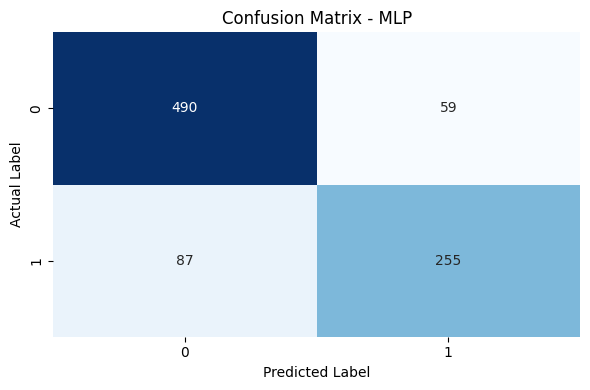

--------------------------------------------------
Evaluating model: RFC
RFC - Accuracy: 0.8126, Precision: 0.7778, Recall: 0.7164


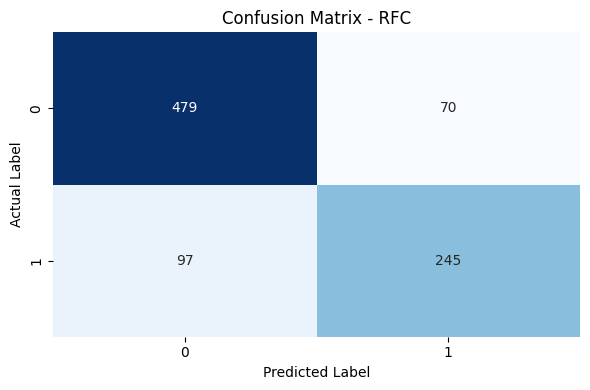

--------------------------------------------------
Evaluating model: SVC
SVC - Accuracy: 0.8316, Precision: 0.7892, Recall: 0.7661


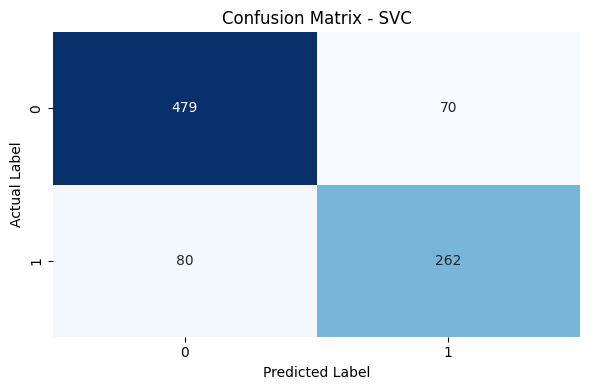

--------------------------------------------------
Evaluating model: AdaB
AdaB - Accuracy: 0.8171, Precision: 0.7640, Recall: 0.7573


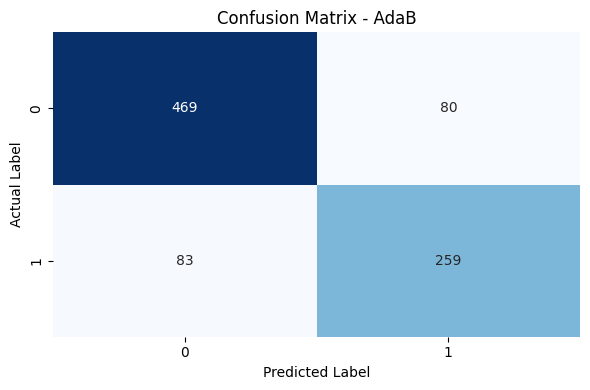

--------------------------------------------------
Evaluating model: GBC
GBC - Accuracy: 0.8283, Precision: 0.8019, Recall: 0.7339


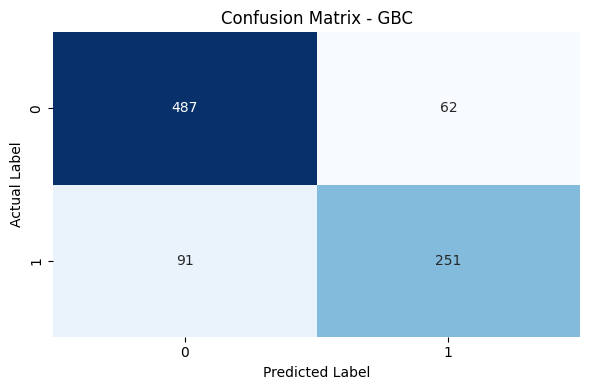

--------------------------------------------------
Evaluating model: DTC
DTC - Accuracy: 0.7969, Precision: 0.7692, Recall: 0.6725


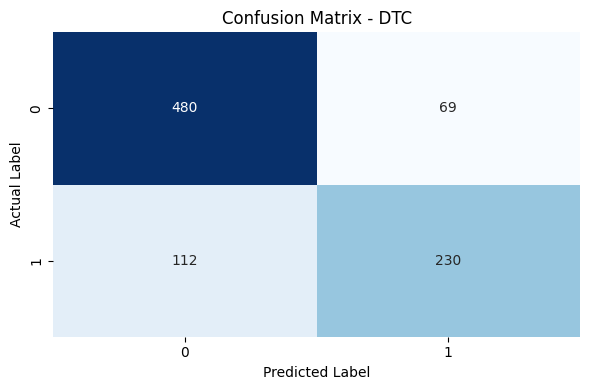

--------------------------------------------------
Evaluating model: XGB
XGB - Accuracy: 0.8182, Precision: 0.7922, Recall: 0.7135


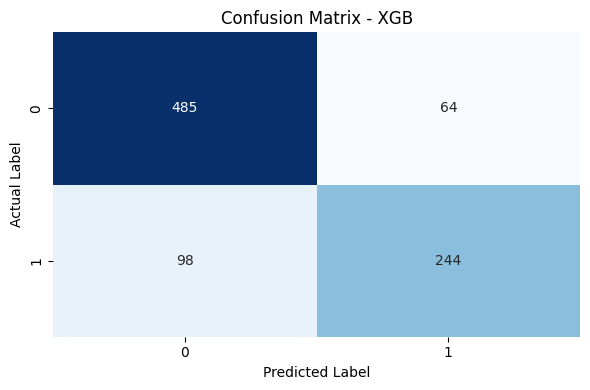

--------------------------------------------------
Evaluating model: LR
LR - Accuracy: 0.8171, Precision: 0.7640, Recall: 0.7573


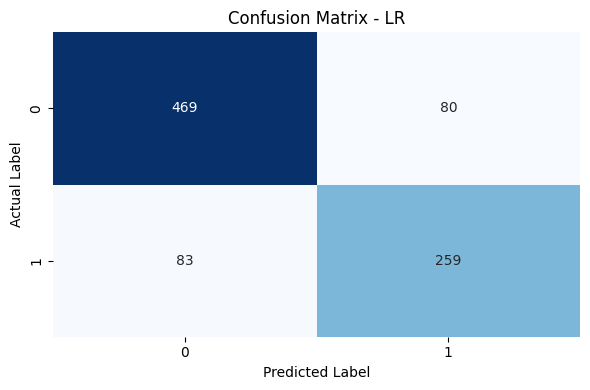

--------------------------------------------------


In [90]:
# Loop through all trained models
for name, model in trained_models.items():
    print(f"Evaluating model: {name}")
    
    # Generate cross-validated predictions
    y_train_pred = cross_val_predict(model, X_train_scaled, y_train_true, cv=cv)
    
    # Compute metrics
    acc = accuracy_score(y_train_true, y_train_pred)
    precision = precision_score(y_train_true, y_train_pred)
    recall = recall_score(y_train_true, y_train_pred)
    
    # Print metrics
    print(f"{name} - Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    
    # Plot confusion matrix
    plot_confusion_matrix(y_train_true, y_train_pred, name)
    print("-"*50)

Evaluating MLP...


C:\Users\Milos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Milos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Milos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Milos\A

Evaluating RFC...
Evaluating SVC...
Evaluating AdaB...
Evaluating GBC...
Evaluating DTC...
Evaluating XGB...
Evaluating LR...
  Model  Accuracy  Precision    Recall        F1
0   MLP  0.821549   0.785047  0.736842  0.760181
1   RFC  0.810325   0.789298  0.690058  0.736349
2   SVC  0.828283   0.787234  0.757310  0.771982
3  AdaB  0.818182   0.764706  0.760234  0.762463
4   GBC  0.822671   0.810811  0.701754  0.752351
5   DTC  0.793490   0.753205  0.687135  0.718654
6   XGB  0.809203   0.772152  0.713450  0.741641
7    LR  0.810325   0.755162  0.748538  0.751836


C:\Users\Milos\AppData\Local\Temp\ipykernel_10196\310970993.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=metrics_df, palette='viridis')
C:\Users\Milos\AppData\Local\Temp\ipykernel_10196\310970993.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=metrics_df, palette='viridis')
C:\Users\Milos\AppData\Local\Temp\ipykernel_10196\310970993.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=metrics_df, palette='viridis')
C:\Users\Milos\AppData\Local\Temp\ipy

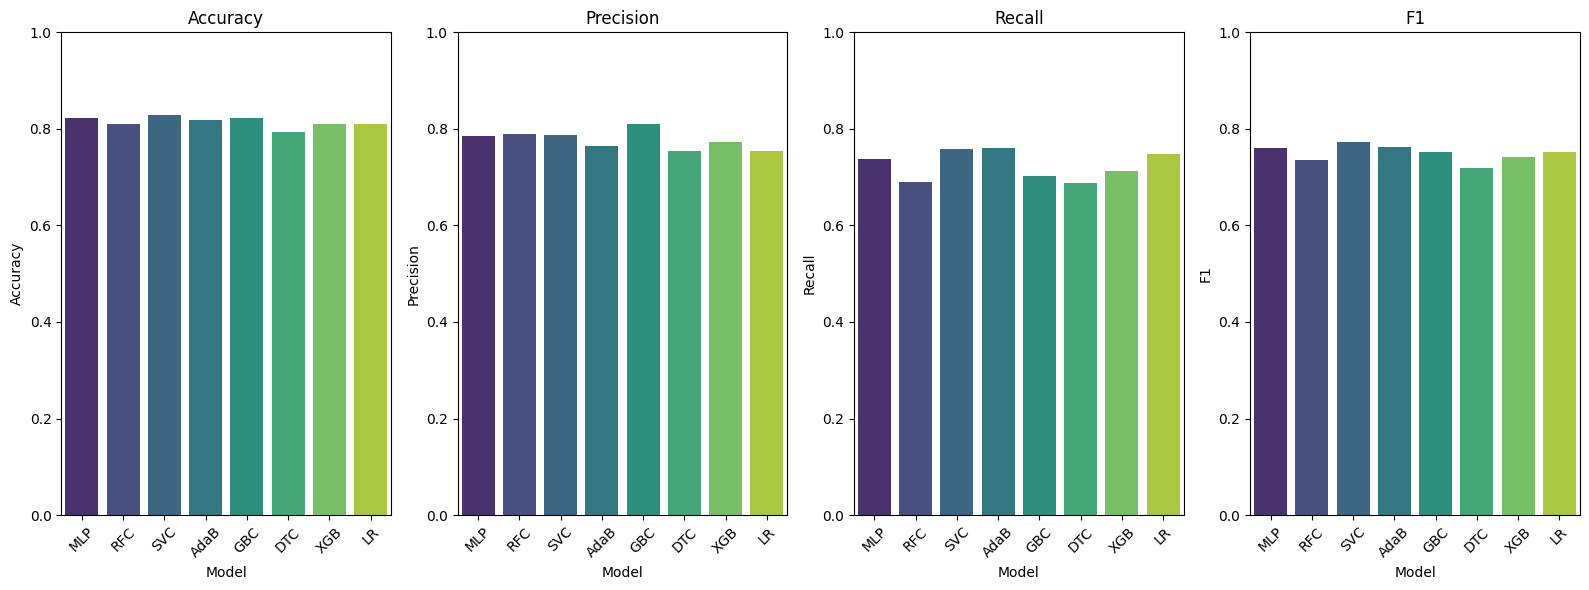

In [91]:
# Dictionary to store results
metrics_summary = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': []
}

# Loop through all trained models
for name, model in models:
    print(f"Evaluating {name}...")
    
    # Get cross-validated predictions
    y_pred = cross_val_predict(model, X_train_scaled, y_train_true, cv=5)
    
    # Calculate metrics
    acc = accuracy_score(y_train_true, y_pred)
    prec = precision_score(y_train_true, y_pred)
    rec = recall_score(y_train_true, y_pred)
    f1 = f1_score(y_train_true, y_pred)
    
    # Store results
    metrics_summary['Model'].append(name)
    metrics_summary['Accuracy'].append(acc)
    metrics_summary['Precision'].append(prec)
    metrics_summary['Recall'].append(rec)
    metrics_summary['F1'].append(f1)

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_summary)
print(metrics_df)

# Plot bar charts for each metric
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1']
plt.figure(figsize=(16, 6))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(1, 4, i)
    sns.barplot(x='Model', y=metric, data=metrics_df, palette='viridis')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.title(metric)

plt.tight_layout()
plt.show()

### Feature Importance

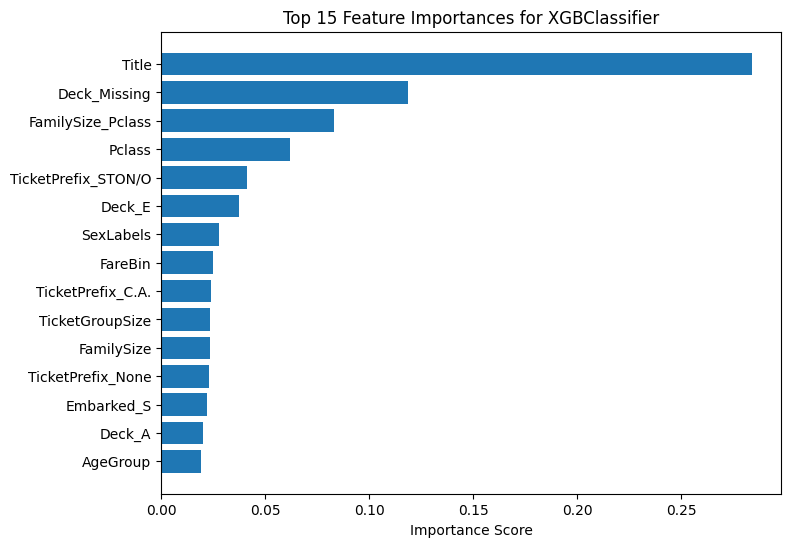

In [92]:
plot_feature_importance(trained_models['XGB'], X_train_scaled.columns)

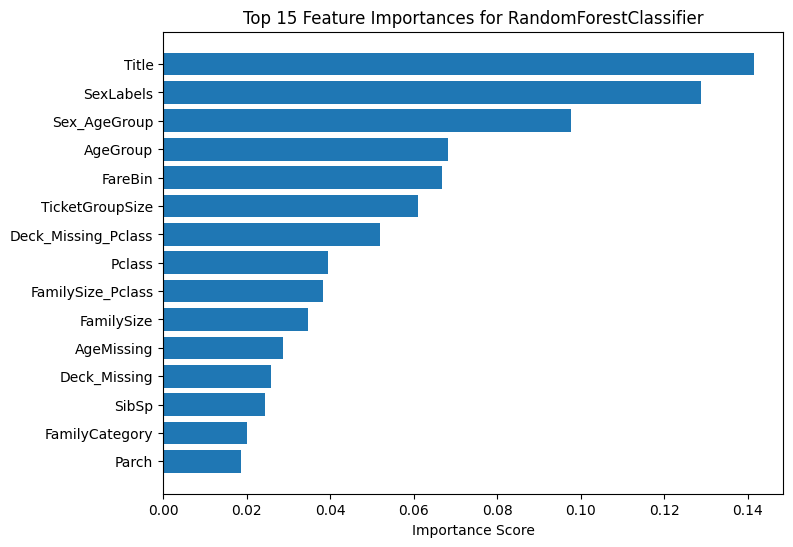

In [93]:
plot_feature_importance(trained_models['RFC'], X_train_scaled.columns)

# HYPERPARAMETER TUNING

In [94]:
# Define models and coarse grids
models_params = {
    "MLP": {
        "model": MLPClassifier(max_iter=500, random_state=42),
        "params": {
            "hidden_layer_sizes": [(50,), (100,)],
            "alpha": [0.0001, 0.001],
            "learning_rate_init": [0.001, 0.01]
        }
    },
    "RFC": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 5, 10],
            "min_samples_split": [2, 5]
        }
    },
    "SVC": {
        "model": SVC(random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["rbf", "linear"],
            "gamma": ["scale", "auto"]
        }
    },
    "AdaB": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.5, 1, 1.5]
        }
    },
    "GBC": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.05, 0.1],
            "max_depth": [3, 5]
        }
    },
    "DTC": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [None, 5, 10],
            "min_samples_split": [2, 5, 10]
        }
    },
    "XGB": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.05, 0.1],
            "max_depth": [3, 5]
        }
    },
    "LR": {
        "model": LogisticRegression(max_iter=500, random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "penalty": ["l2"],
            "solver": ["lbfgs"]
        }
    }
}

In [95]:
# Perform GridSearchCV for each model
best_models = {}
for name, mp in models_params.items():
    print(f"\nRunning GridSearch for {name}...")
    grid = GridSearchCV(mp["model"], mp["params"], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train_true)
    print(f"Best F1: {grid.best_score_:.4f} | Best Params: {grid.best_params_}")
    best_models[name] = grid.best_estimator_


Running GridSearch for MLP...


C:\Users\Milos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Best F1: 0.7572 | Best Params: {'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001}

Running GridSearch for RFC...
Best F1: 0.7700 | Best Params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}

Running GridSearch for SVC...
Best F1: 0.7666 | Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Running GridSearch for AdaB...
Best F1: 0.7707 | Best Params: {'learning_rate': 0.5, 'n_estimators': 200}

Running GridSearch for GBC...
Best F1: 0.7574 | Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

Running GridSearch for DTC...
Best F1: 0.7284 | Best Params: {'max_depth': 5, 'min_samples_split': 5}

Running GridSearch for XGB...


C:\Users\Milos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [23:13:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best F1: 0.7618 | Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

Running GridSearch for LR...
Best F1: 0.7580 | Best Params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


## 7) Making Predictions on TEST SET - USING THE BEST MODEL

In [96]:
# Use the trained XGBoost model from grid search
xgb_model = best_models['XGB']  # your tuned XGB from GridSearch

# Make predictions
y_test_pred = xgb_model.predict(X_test)

# Probabilities (for ROC curves or metrics)
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]

# Create a DataFrame for submission
submission = pd.DataFrame({
    'PassengerId': datasets['test']['PassengerId'],
    'Survived': y_test_pred
})

# Save to CSV
submission.to_csv('titanic_xgb_predictions.csv', index=False)

print("Submission file saved: titanic_xgb_predictions.csv")

Submission file saved: titanic_xgb_predictions.csv


## 🏁 Conclusion

- The MLP and XGB model achieved the highest accuracy of 82%.
- Newly engineered feature Title was the most important predictors of survival.
- Future improvements could include hyperparameter tuning and ensemble stacking.